In [1]:
%load_ext processingpymat

In [2]:
%matplotlib nbagg

In [3]:
import sys
sys.path.append('Tankgame')

In [4]:
from tankai import TankAI, Operation
from ai import AI

class RandomAI(TankAI):
    def __init__(self, name='Unknown'):
        super().__init__()
        self.ai = None
        self.ops = None
        self.name = name
    
    def perform(self, env):
        if self.ai is None:
            self.ai = [AI(10) for h in env.heroes]
            self.ops = [Operation() for h in env.heroes]
        print((self.name, [(h.x, h.y, h.body_rot, h.gun_rot) for h in env.heroes]))
        for ai, op in zip(self.ai, self.ops):
            ai.move(op)
        return self.ops

In [5]:
hero_ai = RandomAI('Legion A')
enemy_ai = RandomAI('Legion B')

In [7]:
class Manager:
    def __init__(self):
        self.logs = []
        
    def reset(self):
        self.logs = []
    
    def log(self, world, heroes, enemies, bullets):
        self.logs.append((world.copy(), [h.copy() for h in heroes], [e.copy() for e in enemies], [b.copy() for b in bullets]))
        
    def get_frames(self):
        count = 0
        while len(self.logs) == 0 or (any([not t.dead for t in self.logs[-1][1]]) and any([not t.dead for t in self.logs[-1][2]])):
            count += 1
            yield count

In [8]:
manager = Manager()

<IPython.core.display.Javascript object>


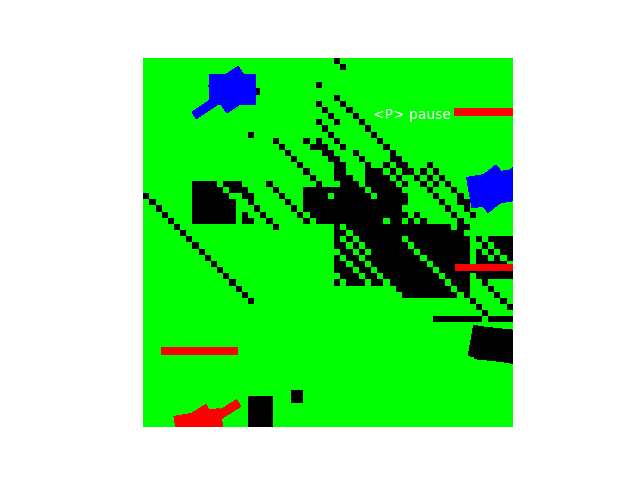

/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


(<processingpymat.processing.Processing at 0x7fe86c28bb10>,
 <matplotlib.animation.FuncAnimation at 0x7fe86c2804d0>)

In [11]:
%%processing skipframes=9
from env import Environment
from world import World
from tank import Tank
from target import Target
from ai import AI
from ui import UI

bullets = []

def setup():
    global grid, target, world, heroes, enemies, ui

    size(240, 240, P2D)
    noSmooth()

    ui = UI()

    world = World(width, height, 4)
    world.create_grid()

    tank = Tank(30, 30, bullets, ui, True)
    world.destroy(70, tank.x, tank.y)
    tank1 = tank
    tank = Tank(240 - 30, 30, bullets, ui, True)
    world.destroy(70, tank.x, tank.y)
    tank2 = tank
    heroes = [tank1, tank2]

    enemy = Tank(30, 240 - 30, bullets, ui, False)
    world.destroy(70,  enemy.x, enemy.y)
    enemy1 = enemy
    enemy = Tank(240 - 30, 240 - 30, bullets, ui, False)
    world.destroy(70,  enemy.x, enemy.y)
    enemy2 = enemy

    #enemy2 = Tank(300, 400, bullets, ui, False)
    #world.destroy(100, 300, 400)

    #enemies = [enemy, enemy2]
    enemies = [enemy1, enemy2]

    noStroke()
    
    # Start game automatically
    ui.state = ui.gameplay


def draw():
    global bullets, world, heroes, enemies, ui

    #background(200, 255, 100)
    background(0, 255, 0)

    world.render()
    
    hero_ops = hero_ai.perform(Environment(world, heroes, enemies, bullets))
    for tank, op in zip(heroes, hero_ops):
        op.applyTo(tank)
    enemy_ops = enemy_ai.perform(Environment(world, enemies, heroes, bullets))
    for tank, op in zip(enemies, enemy_ops):
        op.applyTo(tank)

    for tank in heroes:
        if ui.state == ui.gameplay:
            tank.update(world)
        tank.render(False)

    for enemy in enemies:
        if ui.state == ui.gameplay:
            enemy.update(world)
        enemy.render(False)

    destroyed = []
    for i, bullet in enumerate(bullets):

        destroy = False

        if bullet.x < 0 or bullet.x > width or bullet.y < 0 or bullet.y > height:
            destroy = True
        else:

            for tank in heroes:
                if bullet.x > tank.x-tank._height/2 and bullet.x < tank.x+tank._height/2 and bullet.y > tank.y-tank._height/2 and bullet.y < tank.y+tank._height/2:
                    tank.hit()
                    destroy = True
                    continue

            for enemy in enemies:

                if bullet.x > enemy.x-enemy._height/2 and bullet.x < enemy.x+enemy._height/2 and bullet.y > enemy.y-enemy._height/2 and bullet.y < enemy.y+enemy._height/2:
                    enemy.hit()
                    destroy = True
                    continue

            if world.grid[min(int(bullet.y / world.cell_size), len(world.grid) - 1)][min(int(bullet.x / world.cell_size), len(world.grid[0]) - 1)] == 1:

                world.destroy(int(random(20, 40)), int(bullet.x), int(bullet.y))
                destroy = True

        if destroy:
            destroyed.append(i)
            continue

        if ui.state == ui.gameplay:
            bullet.update()
        bullet.render()
        
    for d in destroyed[::-1]:
        bullets.pop(d)
    manager.log(world, heroes, enemies, bullets)

    ui.render()

<IPython.core.display.Javascript object>


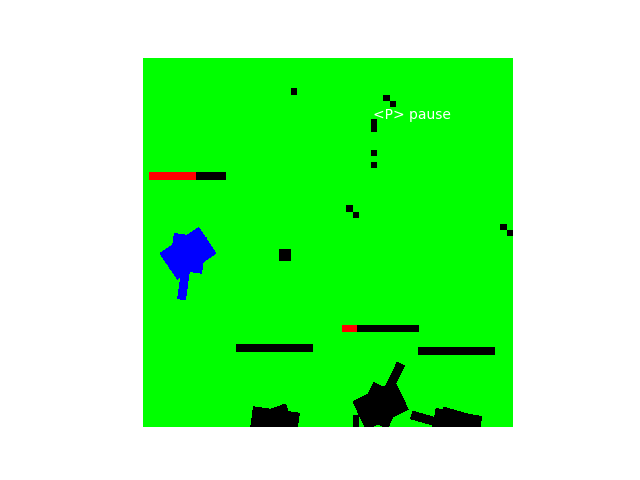

('Legion A', [(30, 30, 0, 0), (210, 30, 0, 0)])
('Legion B', [(30, 210, 0, 0), (210, 210, 0, 0)])
('Legion A', [(21.006091729809043, 29.65100503297499, 0, 2), (201.00548255682813, 29.68590452967749, 2, 2)])
('Legion B', [(21.005482556828138, 209.6859045296775, 2, 2), (201.00548255682813, 210.3140954703225, -2, -2)])
('Legion A', [(22.006091729809043, 29.65100503297499, 0, 4), (202.00304660708795, 29.755661003421615, 4, 4)])
('Legion B', [(22.003046607087963, 209.7556610034216, 4, 4), (202.00304660708795, 210.2443389965784, -4, -4)])
('Legion A', [(23.006091729809043, 29.65100503297499, 0, 6), (202.99756850245623, 29.860189466689267, 6, 6)])
('Legion B', [(22.997568502456236, 209.86018946668926, 6, 6), (202.99756850245623, 210.13981053331074, -6, -6)])
('Legion A', [(24.006091729809043, 29.65100503297499, 0, 8), (203.9878365711978, 29.99936256764933, 8, 8)])
('Legion B', [(23.987836571197807, 209.99936256764934, 8, 8), (203.9878365711978, 210.00063743235066, -8, -8)])
('Legion A', [(25.

In [12]:
proc = %lastprocess
manager.reset()
proc.generate(frames=manager.get_frames, skipframes=59)

In [13]:
manager.logs

[(<world.World at 0x7fe865b42c90>,
  [<tank.Tank at 0x7fe865b82310>, <tank.Tank at 0x7fe865b82dd0>],
  [<tank.Tank at 0x7fe865b82e90>, <tank.Tank at 0x7fe865b82c10>],
   <bullet.Bullet at 0x7fe865b82710>]),
 (<world.World at 0x7fe865b82ed0>,
  [<tank.Tank at 0x7fe865b82250>, <tank.Tank at 0x7fe865b82450>],
  [<tank.Tank at 0x7fe865b82850>, <tank.Tank at 0x7fe865b823d0>],
  [<bullet.Bullet at 0x7fe865b82210>, <bullet.Bullet at 0x7fe865b82150>]),
 (<world.World at 0x7fe865b822d0>,
  [<tank.Tank at 0x7fe865b82350>, <tank.Tank at 0x7fe865b82d90>],
  [<tank.Tank at 0x7fe865b82890>, <tank.Tank at 0x7fe865bb5b90>],
  []),
 (<world.World at 0x7fe865b82390>,
  [<tank.Tank at 0x7fe865bb5d90>, <tank.Tank at 0x7fe865bb5550>],
  [<tank.Tank at 0x7fe865bb58d0>, <tank.Tank at 0x7fe865bb5650>],
  []),
 (<world.World at 0x7fe865b82650>,
  [<tank.Tank at 0x7fe865bb5750>, <tank.Tank at 0x7fe865bb5b50>],
  [<tank.Tank at 0x7fe865bb5d10>, <tank.Tank at 0x7fe865bb5490>],
  []),
 (<world.World at 0x7fe865bb5

<IPython.core.display.Javascript object>


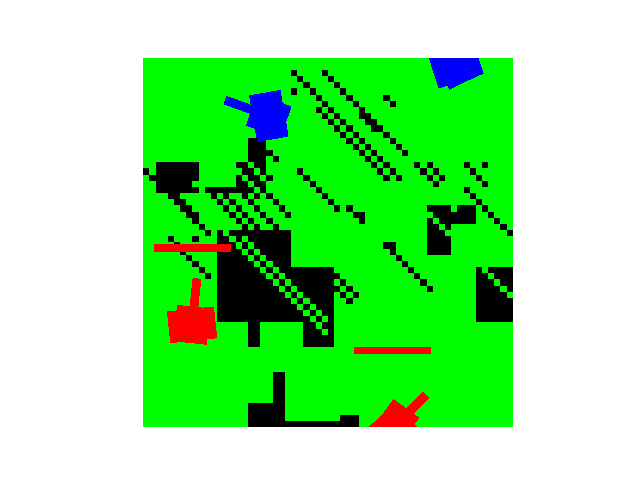

(<processingpymat.processing.Processing at 0x7fe85a760710>,
 <matplotlib.animation.FuncAnimation at 0x7fe85a50e910>)

In [20]:
%%processing skipframes=4
def setup():
    size(240, 240, P2D)
    noSmooth()
    noStroke()
    
    global frame
    frame = 0


def draw():
    global frame

    #background(200, 255, 100)
    background(0, 255, 0)
    
    if frame >= len(manager.logs):
        return

    world, heroes, enemies, bullets = manager.logs[frame]
    
    frame += 1

    world.render()

    for tank in heroes:
        tank.render(False)

    for enemy in enemies:
        enemy.render(False)

    for bullet in bullets:
        bullet.render()

<IPython.core.display.Javascript object>


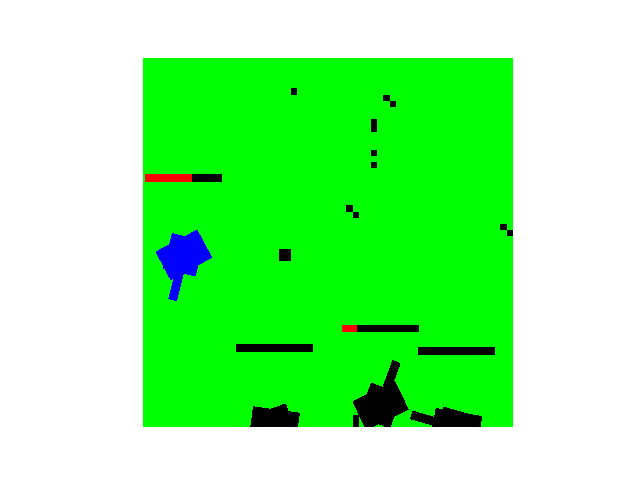

/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


Draw(frame=0): duration=0.675979 seconds.
Draw(frame=0): duration=0.041165 seconds.
Draw(frame=1, skipframe=0): duration=0.001395 seconds.
Draw(frame=1, skipframe=1): duration=0.001056 seconds.
Draw(frame=1, skipframe=2): duration=0.001006 seconds.
Draw(frame=1, skipframe=3): duration=0.000769 seconds.
Draw(frame=1): duration=0.030876 seconds.
Draw(frame=2, skipframe=0): duration=0.000845 seconds.
Draw(frame=2, skipframe=1): duration=0.000976 seconds.
Draw(frame=2, skipframe=2): duration=0.000842 seconds.
Draw(frame=2, skipframe=3): duration=0.00098 seconds.
Draw(frame=2): duration=0.022046 seconds.
Draw(frame=3, skipframe=0): duration=0.000816 seconds.
Draw(frame=3, skipframe=1): duration=0.000815 seconds.
Draw(frame=3, skipframe=2): duration=0.000823 seconds.
Draw(frame=3, skipframe=3): duration=0.001059 seconds.
Draw(frame=3): duration=0.024437 seconds.
Draw(frame=4, skipframe=0): duration=0.000848 seconds.
Draw(frame=4, skipframe=1): duration=0.00112 seconds.
Draw(frame=4, skipfram

In [22]:
proc = %lastprocess
proc.generate(frames=len(manager.logs), skipframes=4, debug=True)